In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb

import sys
print(sys.executable)

/Users/madelinemiller/Desktop/data_literacy/geonews_femicide/source/.venv/bin/python


In [2]:
#set source and output paths
source_path = '../../data/'
csv_output_path = '../../data/processed/'
figure_output_path = '../../paper/figures/'

#upload raw query data
df_32_raw = pd.read_csv(f'{source_path}repository_queries/500000_32_homicide-female_DE.csv') 
#upload manually tagged articles with json data
df_tag = pd.read_csv(f'{source_path}processed/manual-tag_all_parsedson.csv') 
#upload keyword data
df_key = pd.read_csv(f'{source_path}manual_tag/femicide_keywords.csv') 

#filter to only one entry per NUTS
df_32_raw['NUTS'] = df_32_raw['NUTS'].fillna('').astype(str)
df_32 = df_32_raw.groupby('id').agg({
    'NUTS': lambda x: ', '.join(sorted(set(code for code in x if code.startswith('DE')))),
    'url': 'first',
    'hostname': 'first',
    'date': 'first',
    'cos_dist': 'first' # these values will all be the same
    }).reset_index()

In [3]:
#get subsets of sampled and checked articles

#ids that were sampled and had a T/F outcome 
#filter out nan for 'query_32_cosine_bin' and 'woman_murdered'
#select only id
df_sampled = df_tag.dropna(subset=['query_32_cosine_bin', 'woman_murdered'])
#get list of ids
sampled_ids = df_sampled['id']
#filter raw dataset to just those ids
df_32_sampled = df_32[df_32['id'].isin(sampled_ids)].copy()

#all ids that were manualy checked that had a T/F outcome
#filter out nan for 'woman_murdered'
df_checked = df_tag[df_tag['woman_murdered'].notna()]
#get list of ids
checked_ids = df_checked['id']
#filter raw dataset to just those ids
df_32_checked = df_32[df_32['id'].isin(checked_ids)].copy()


# Verify the result
print(f"Original shape: {df_tag.shape}")
print(f"sample shape: {df_sampled.shape}")
print(f"all checked shape: {df_checked.shape}")
print(f"32 sample shape: {df_32_sampled.shape}")
print(f"32 all checked shape: {df_32_checked.shape}") 
#less than all checked because some checked articles were not included in q 32 results

#add relevance col
if 'woman_murdered' not in df_32_checked.columns:
    df_32_checked = df_32_checked.merge(
        df_tag[['id', 'woman_murdered']], 
        on='id', 
        how='left'
    ).copy()

# create dataframe for relevant
df_relevant = df_32_checked[df_32_checked['woman_murdered'] == True]
print(f"32 all checked RELEVANT shape: {df_relevant.shape}") 

# create dataframe for irrelevant
df_irrelevant = df_32_checked[df_32_checked['woman_murdered'] == False]
print(f"32 all checked IRRELEVANT shape: {df_irrelevant.shape}") 

n_r = df_relevant.shape[0] # number of relevant articles
n_i = df_irrelevant.shape[0] # number of irrelevant articles

Original shape: (1666, 20)
sample shape: (677, 20)
all checked shape: (1028, 20)
32 sample shape: (677, 6)
32 all checked shape: (1014, 6)
32 all checked RELEVANT shape: (648, 7)
32 all checked IRRELEVANT shape: (366, 7)


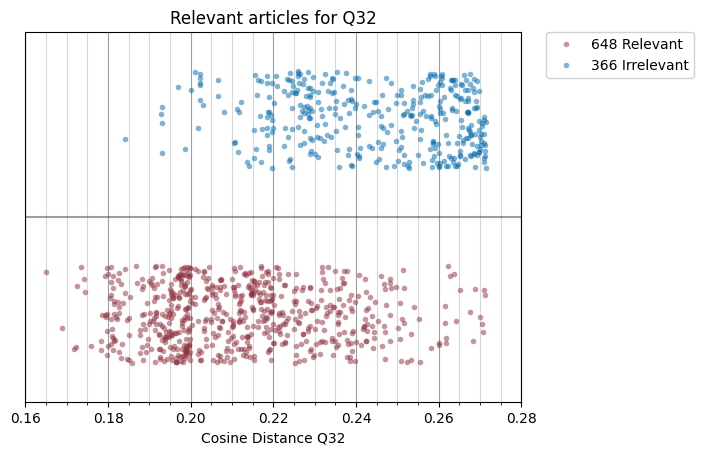

In [4]:
fig, ax = plt.subplots()
ax.set_title("Relevant articles for Q32")
ax.set_xlabel("Cosine Distance Q32")

np.random.seed(1)
u_i = np.random.rand(n_i)
u_r = np.random.rand(n_r)

ax.plot(
    df_relevant["cos_dist"],
    0.5 * u_r,
    "o",
    label=f"{n_r} Relevant",
    color=rgb.tue_red,
    alpha=0.5,
    mec="none",
    ms=4,
)
ax.plot(
    df_irrelevant["cos_dist"],
    1 + 0.5 * u_i,
    "o",
    label=f"{n_i} Irrelevant",
    color=rgb.tue_blue,
    alpha=0.5,
    mec="none",
    ms=4,
)

# set the x-axis formatter to the custom function
ax.set_xlim(.16, .28)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.02)) # Ticks at .16, .18, .20, etc.
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.005))
ax.legend(loc="upper left", 
    bbox_to_anchor=(1.05, 1), 
    borderaxespad=0., 
    framealpha=0.9, 
    facecolor="white")
ax.grid(axis="x", which="major", alpha=0.5, color=rgb.tue_dark)
ax.grid(axis="x", which="minor", alpha=0.5, color=rgb.tue_gray)
ax.yaxis.set_visible(False)
ax.axhline(0.75, color=rgb.tue_dark, alpha=0.5)
ax.set_ylim(-0.2, 1.7)

fig.savefig(f"{figure_output_path}cosdist_scatter.pdf")

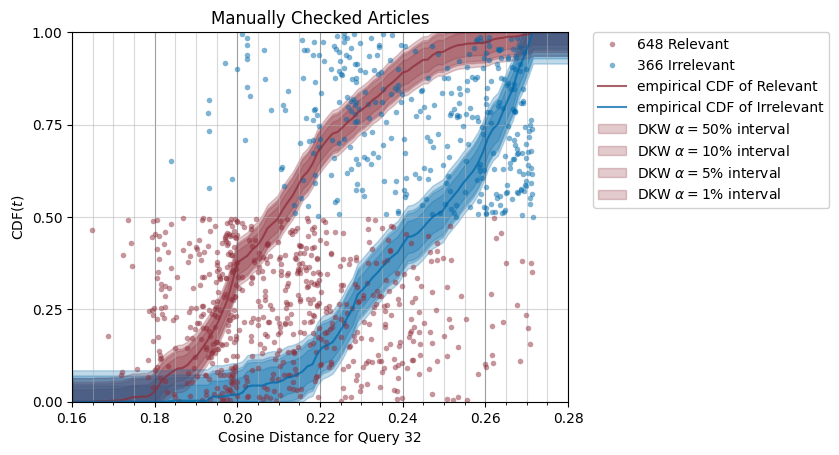

In [6]:
# empirical CDFs:
y = np.linspace(.16, .28, 100)
cdf_r = np.array([np.sum(df_relevant["cos_dist"] <= yi) for yi in y]) / len(df_relevant["cos_dist"])
cdf_i = np.array([np.sum(df_irrelevant["cos_dist"] <= yi) for yi in y]) / len(df_irrelevant["cos_dist"])

# plt.rcParams.update(bundles.beamer_moml(rel_width=0.3))
fig, ax = plt.subplots()
ax.set_title("Manually Checked Articles")
ax.set_xlabel("Cosine Distance for Query 32")

np.random.seed(1)
u_i = np.random.rand(n_i)
u_r = np.random.rand(n_r)

ax.plot(
    df_relevant["cos_dist"],
    0.5 * u_r,
    "o",
    label=f"{n_r} Relevant",
    color=rgb.tue_red,
    alpha=0.5,
    mec="none",
    ms=4,
)
ax.plot(
    df_irrelevant["cos_dist"],
    0.5 * u_i + 0.5,
    "o",
    label=f"{n_i} Irrelevant",
    color=rgb.tue_blue,
    alpha=0.5,
    mec="none",
    ms=4,
)

# empirical CDFs:
y = np.linspace(.16, .28, 100)
cdf_f = np.array([np.sum(df_relevant["cos_dist"] <= yi) for yi in y]) / len(
    df_relevant["cos_dist"]
)
cdf_m = np.array([np.sum(df_irrelevant["cos_dist"] <= yi) for yi in y]) / len(
    df_irrelevant["cos_dist"]
)

ax.plot(y, (cdf_r), color=rgb.tue_red, alpha=0.75, label="empirical CDF of Relevant")
ax.plot(y, cdf_i, color=rgb.tue_blue, alpha=0.75, label="empirical CDF of Irrelevant")

for alpha in [0.5, 0.1, 0.05, 0.01]:
    DKW_f_lower = np.array(
        [
            np.max([0, cdf_r[i] - np.sqrt(np.log(2 / alpha) / (2 * n_r))])
            for i in range(len(y))
        ]
    )
    DKW_f_upper = np.array(
        [
            np.min([1, cdf_r[i] + np.sqrt(np.log(2 / alpha) / (2 * n_r))])
            for i in range(len(y))
        ]
    )
    DKW_m_lower = np.array(
        [
            np.max([0, cdf_i[i] - np.sqrt(np.log(2 / alpha) / (2 * n_i))])
            for i in range(len(y))
        ]
    )
    DKW_m_upper = np.array(
        [
            np.min([1, cdf_i[i] + np.sqrt(np.log(2 / alpha) / (2 * n_i))])
            for i in range(len(y))
        ]
    )

    ax.fill_between(
        y,
        DKW_f_lower,
        DKW_f_upper,
        color=rgb.tue_red,
        alpha=0.25,
        label=fr"DKW $\alpha={alpha * 100:.0f}\%$ interval",
    )
    ax.fill_between(
        y,
        DKW_m_lower,
        DKW_m_upper,
        color=rgb.tue_blue,
        alpha=0.25,
        # label=fr"DKW $\alpha={alpha * 100:.0f}\%$ interval of irrelevant",
    )

# set the x-axis formatter to the custom function
ax.set_xlim(.16, .28)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.02)) # Ticks at .16, .18, .20, etc.
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.005))
ax.legend(loc="upper left", 
    bbox_to_anchor=(1.05, 1), 
    borderaxespad=0., 
    framealpha=0.9, 
    facecolor="white")
ax.grid(axis="x", which="major", alpha=0.5, color=rgb.tue_dark)
ax.grid(axis="x", which="minor", alpha=0.5, color=rgb.tue_gray)
# ax.yaxis.set_visible(False)
ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
ax.grid(axis="y", which="major", alpha=0.5)
ax.set_ylabel("CDF($t$)")

fig.savefig(f"{figure_output_path}cosdist_cdf_scatter.pdf")

In [ ]:
#repeat above but with rank, not cosine distance, and one row for each query